## 🤖🔁🤖 **Building Multi-Agent Systems (MaS) with Semantick Kernel (SK) Agent Framework (Experimental)**

> **Note:** The [Semantic Kernel (SK) Agent Framework](https://learn.microsoft.com/en-us/semantic-kernel/frameworks/agent/agent-architecture?pivots=programming-language-csharp) is currently in preview and may change.

The SK Agent Framework builds on the core Semantic Kernel by introducing advanced multi-agent collaboration and support for handling multiple conversations concurrently.

### **Understanding key features of the SK agent framework**

#### **1. The Kernel: Your AI “Engine”**
**What It Is:** Think of the Kernel as the “brain” or “engine” that powers all AI tasks. It manages large language models (like GPT), keeps track of context, and handles any advanced computations needed for agents to work properly.

**Why It Matters:** Without the Kernel, an agent wouldn’t “know” anything or be able to process natural language. It’s the foundation that makes intelligence possible.

#### **2. The Agent: A Specialized “Persona”**
**What It Is:** An Agent is like a “persona” or “role” that uses the Kernel’s AI capabilities. Each agent has its own personality and purpose:
- **Kernel Agent**: Ties directly to a Kernel object, using its full range of AI services.
- **Chat Completion Agent, Open AI Assistant Agent**: Specialized agents that build on the Kernel’s intelligence.

**Why It Matters:** The Agent decides how to use the Kernel. It interprets requests, provides responses, and can perform specialized tasks by calling the Kernel’s functions (or plugins).

#### **3. The Agent Chat: Where Collaboration Happens**
**What It Is:** An Agent Chat is like a virtual room (or a group chat) where one or more agents—and possibly human users—come together to share messages or solve problems.
- **Group Chat**: Manages multiple agents at once, each taking a different role.

**Why It Matters:** In this “room,” the agents can talk to each other or to a human user, coordinate tasks, and respond dynamically. This makes it easy to build multi-agent scenarios (like a customer support chat or a project management tool).

#### **4. The Agent Channel: The “Connector”**
**What It Is:** The Agent Channel is an internal connector that plugs different agents into an Agent Chat.

**Why It Matters:** Most of the time, end users don’t see or deal with the Agent Channel. It’s mainly for developers who want to create custom agents and make them seamlessly join existing chats.

#### **How They All Work Together**
- **Kernel (Engine)**: Powers the AI capabilities (language understanding, context, etc.).
- **Agent (Persona)**: Uses the Kernel to interpret questions, generate answers, and perform tasks. Each agent can be specialized for a different job or function.
- **Agent Chat (Collaboration Space)**: Brings multiple agents—and possibly humans—together in a single conversation or multiple concurrent conversations.
- **Agent Channel (Internal Connector)**: Ensures any newly created or custom agent can easily join the chat with minimal setup.

For example: 
1. **Kernel Configuration**: You have a Kernel configured to use GPT-like models.
2. **Create Agent**: You create a Chat Completion Agent that “speaks” using these models.
3. **Add to Chat**: You add this agent to an Agent Chat, where it can interact with you and other agents in the same “room.”
4. **New Agent**: If you build a new Finance Agent, you connect it using the Agent Channel so it can also join the conversation.
5. **Collaboration**: Both agents can collaborate: the Chat Completion Agent handles general queries while the Finance Agent handles specific financial calculations—both powered by the same Kernel behind the scenes.

#### In short: 
- **Kernel**: The AI powerhouse.
- **Agent**: The role/persona that uses the Kernel’s intelligence.
- **Agent Chat**: The place where agents (and humans) communicate and collaborate.
- **Agent Channel**: The behind-the-scenes connector that lets different agents join the chat.

This design makes it easy to scale from a single-agent scenario to a multi-agent environment, all while staying consistent with Semantic Kernel’s [underlying architecture](https://learn.microsoft.com/en-us/semantic-kernel/frameworks/agent/agent-architecture?pivots=programming-language-csharp).

### **Prerequisites for Running the Notebook**

To run this notebook, you need to first upload your data to the Azure AI service and configure the necessary settings. Follow these steps:

1. **Run the Indexing Policies Notebook to upload data to Azure AI search**: Execute the code in the `utils\indexing-policies.ipynb`


In [6]:
import os
import pprint

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab


In [7]:
#!pip install semantic-kernel --upgrade
import semantic_kernel as sk

print(f"We are using the following semantic_kernel library version: {sk.__version__}")

We are using the following semantic_kernel library version: 1.20.0


In [8]:
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.agents import AgentGroupChat, ChatCompletionAgent
from semantic_kernel.agents.strategies import (
    KernelFunctionSelectionStrategy,
    KernelFunctionTerminationStrategy,
)
from semantic_kernel.connectors.ai.open_ai.services.azure_chat_completion import (
    AzureChatCompletion,
)
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions.kernel_function_from_prompt import (
    KernelFunctionFromPrompt,
)
from semantic_kernel.kernel import Kernel
import logging

In [9]:
from src.prompts.prompt_manager import PromptManager
from src.aoai.azure_openai import AzureOpenAIManager

# Create the Azure OpenAI object
azure_openai_client = AzureOpenAIManager()
prompt_manager = PromptManager()

Templates found: ['evaluator_system_prompt.jinja', 'evaluator_user_prompt.jinja', 'formulator_system_prompt.jinja', 'formulator_user_prompt.jinja', 'query_classificator_system_prompt.jinja', 'query_classificator_user_prompt.jinja']


In [10]:
system_prompt = prompt_manager.get_prompt("query_classificator_system_prompt.jinja")
user_prompt = prompt_manager.create_prompt_query_classifier_user(query="what's up")

response = await azure_openai_client.generate_chat_response(
    query=user_prompt,
    system_message_content=system_prompt,
    conversation_history=[],
    response_format="json_object",
    max_tokens=20,
    temperature=0,  # ensures more deterministic output
)

2025-02-09 16:54:57,126 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-02-09 16:54:57 (azure_openai.py:generate_chat_response:368)
2025-02-09 16:54:57,127 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-02-09 16:54:57 (azure_openai.py:generate_chat_response:425)
2025-02-09 16:54:58,258 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-02-09 16:54:58 (Duration: 1.13 seconds) (azure_openai.py:generate_chat_response:479)


### **Creating a Single Agent**

This section demonstrates how to create a single agent using the Agent class from the `src.agenticai.agents` module. I have built a wrapper on top of the Semantic Kernel SDK to simplify agent initialization; however, please refer to `src.agenticai.agents` for additional details and components of the underlying class `ChatCompletionAgent`.

The agent can be configured with optional parameters for service configuration, instructions, skills, and execution behavior.

#### Parameters:

- `service_id`: The service ID for the agent.
- `name`: The name of the agent.
- `id`: The ID of the agent.
- `description`: A description of the agent.
- `instructions`: The instructions for the agent.
- `skills` (optional): A list of plugin names (skills) to load.
- `execution_settings` (optional): Execution settings for the agent.
- `function_choice_behavior` (optional): Function selection behavior.
- `tracing_enabled` (optional): A flag to enable or disable tracing.

### **🤖 Agent 1 `The Formulator`**

The Formulator agent is designed to create optimized search queries based on provided clinical metadata. This agent analyzes the metadata, identifies key details, and formulates a precise query to retrieve relevant information.

In [11]:
from semantic_kernel.connectors.ai.prompt_execution_settings import (
    PromptExecutionSettings,
)
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)
from src.agenticai.multiagents import Agent

# Agent Instructions
FORMULATOR_NAME = "Formulator"
FORMULATOR_INSTRUCTIONS = """
You are responsible for formulating the query based on the given clinical metadata.
Your job is to analyze the metadata, identify key details, and create an optimized search query.
Output only the query string with no additional text.
"""

# Correct Execution Settings
execution_settings = PromptExecutionSettings(
    service_id="formulator",
    extension_data={"temperature": 0.0, "max_tokens": 2000, "top_p": 0.8},
    function_choice_behavior=FunctionChoiceBehavior.Auto(),  # Fixed instantiation
)

# Instantiate the agent
agent_formulator = Agent(
    service_id="formulator",
    name=FORMULATOR_NAME,
    description="A custom agent for specific tasks.",
    instructions=FORMULATOR_INSTRUCTIONS,
    execution_settings=execution_settings,
    skills=["rewriting"],
    tracing_enabled=True,
)

print("CustomAgent initialized successfully!")

2025-02-09 16:54:58,837 - CustomAgent-Formulator - MainProcess - DEBUG    CustomAgent fully initialized. (multiagents.py:_model_post_init__:96)
2025-02-09 16:54:58,838 - SkillsManager - MainProcess - DEBUG    Skills manager initialized with parent directory: C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab\src\agenticai\plugins\plugins_store (skills.py:__init__:75)
2025-02-09 16:54:58,839 - SkillsManager - MainProcess - DEBUG    Attempting to load skill: rewriting (skills.py:load_skills:88)
2025-02-09 16:54:58,840 - SkillsManager - MainProcess - INFO     Successfully loaded skill: rewriting (skills.py:load_skills:94)


Templates found: ['evaluator_system_prompt.jinja', 'evaluator_user_prompt.jinja', 'formulator_system_prompt.jinja', 'formulator_user_prompt.jinja', 'query_classificator_system_prompt.jinja', 'query_classificator_user_prompt.jinja']


2025-02-09 16:54:59,439 - AIQueryFormulationPlugin - MainProcess - INFO     OpenAI client initialized successfully. (formualtor.py:__init__:80)
[2025-02-09 16:54:59 - AIQueryFormulationPlugin:80 - INFO] OpenAI client initialized successfully.
[2025-02-09 16:54:59 - semantic_kernel.functions.kernel_plugin:333 - WARNING] Failed to create function from Python file: C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab\src\agenticai\plugins\plugins_store\rewriting\__init__.py
2025-02-09 16:54:59,445 - CustomAgent-Formulator - MainProcess - INFO     Successfully integrated plugin: rewriting (multiagents.py:_load_skills:204)
[2025-02-09 16:54:59 - CustomAgent-Formulator:204 - INFO] Successfully integrated plugin: rewriting


CustomAgent initialized successfully!


In [12]:
agent_formulator.kernel.plugins

{'rewriting': KernelPlugin(name='rewriting', description=None, functions={'generate_expanded_query': KernelFunctionFromMethod(metadata=KernelFunctionMetadata(name='generate_expanded_query', plugin_name='rewriting', description='Creates an optimized search query in JSON format using query expansion techniques.', parameters=[KernelParameterMetadata(name='diagnosis', description='Diagnosis and Medical Justification', default_value=None, type_='str', is_required=True, type_object=<class 'str'>, schema_data={'type': 'string', 'description': 'Diagnosis and Medical Justification'}, include_in_function_choices=True), KernelParameterMetadata(name='medication_or_procedure', description='Medication or Procedure', default_value=None, type_='str', is_required=True, type_object=<class 'str'>, schema_data={'type': 'string', 'description': 'Medication or Procedure'}, include_in_function_choices=True), KernelParameterMetadata(name='code', description='Relevant Code (if any)', default_value=None, type_=

### **🤖 Agent 2: The Retriever**

The Retriever agent is designed to retrieve content from Azure AI Search based on provided queries. This agent analyzes the query, determines the most effective retrieval strategy, and returns the top document results.

### Responsibilities

- **Retrieve Content**: Use the provided query to search the Azure AI Search database and retrieve relevant documents.
- **Determine Retrieval Strategy**: Analyze the query to determine the most effective retrieval strategy. Classify the query as either 'keyword' or 'semantic' before performing the search.
- **Handle No Results**: If no relevant content is found, state 'No relevant content found.'


In [13]:
from semantic_kernel.connectors.ai.prompt_execution_settings import (
    PromptExecutionSettings,
)
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)

# Agent Instructions
RETRIEVER_NAME = "Retriever"
RETRIEVER_INSTRUCTIONS = """
You are responsible for retrieving content from Azure AI Search.
Use the provided query to search the database and return the top document results.
Please make sure to determine the retrieval strategy based on the query. Classify the query first and then retrieve the information.
If there are no results, state 'No relevant content found.'
"""

# Correct Execution Settings
execution_settings = PromptExecutionSettings(
    service_id="retriever",
    extension_data={"temperature": 0.0, "max_tokens": 2000, "top_p": 0.8},
    function_choice_behavior=FunctionChoiceBehavior.Auto(),  # Fixed instantiation
)

# Instantiate the agent
agent_retriever = Agent(
    service_id="retriever",
    name=RETRIEVER_NAME,
    description="A custom agent for specific tasks.",
    instructions=RETRIEVER_INSTRUCTIONS,
    execution_settings=execution_settings,
    skills=["retrieval"],
    tracing_enabled=True,
)

print("CustomAgent initialized successfully!")

2025-02-09 16:55:00,024 - CustomAgent-Retriever - MainProcess - DEBUG    CustomAgent fully initialized. (multiagents.py:_model_post_init__:96)
[2025-02-09 16:55:00 - CustomAgent-Retriever:96 - DEBUG] CustomAgent fully initialized.
2025-02-09 16:55:00,027 - SkillsManager - MainProcess - DEBUG    Skills manager initialized with parent directory: C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab\src\agenticai\plugins\plugins_store (skills.py:__init__:75)
[2025-02-09 16:55:00 - SkillsManager:75 - DEBUG] Skills manager initialized with parent directory: C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab\src\agenticai\plugins\plugins_store
2025-02-09 16:55:00,029 - SkillsManager - MainProcess - DEBUG    Attempting to load skill: retrieval (skills.py:load_skills:88)
[2025-02-09 16:55:00 - SkillsManager:88 - DEBUG] Attempting to load skill: retrieval
2025-02-09 16:55:00,033 - SkillsManager - MainProcess - INFO     Successfully loaded skill: retrieval (skills.py:load_skills:94)
[2025-0

Templates found: ['evaluator_system_prompt.jinja', 'evaluator_user_prompt.jinja', 'formulator_system_prompt.jinja', 'formulator_user_prompt.jinja', 'query_classificator_system_prompt.jinja', 'query_classificator_user_prompt.jinja']


2025-02-09 16:55:00,903 - AIQueryClassificationPlugin - MainProcess - INFO     OpenAI client initialized successfully. (aisearchclassification.py:__init__:62)
[2025-02-09 16:55:00 - AIQueryClassificationPlugin:62 - INFO] OpenAI client initialized successfully.
[2025-02-09 16:55:00 - semantic_kernel.functions.kernel_plugin:333 - WARNING] Failed to create function from Python file: C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab\src\agenticai\plugins\plugins_store\retrieval\__init__.py
2025-02-09 16:55:00,915 - CustomAgent-Retriever - MainProcess - INFO     Successfully integrated plugin: retrieval (multiagents.py:_load_skills:204)
[2025-02-09 16:55:00 - CustomAgent-Retriever:204 - INFO] Successfully integrated plugin: retrieval


CustomAgent initialized successfully!


In [14]:
agent_retriever.kernel.plugins

{'retrieval': KernelPlugin(name='retrieval', description=None, functions={'hybrid_search': KernelFunctionFromMethod(metadata=KernelFunctionMetadata(name='hybrid_search', plugin_name='retrieval', description='Performs a hybrid search using both keyword and vector search techniques.', parameters=[KernelParameterMetadata(name='search_text', description=None, default_value=None, type_='str', is_required=True, type_object=<class 'str'>, schema_data={'type': 'string'}, include_in_function_choices=True), KernelParameterMetadata(name='top', description=None, default_value=5, type_='int', is_required=False, type_object=<class 'int'>, schema_data={'type': 'integer'}, include_in_function_choices=True)], is_prompt=False, is_asynchronous=False, return_parameter=KernelParameterMetadata(name='return', description='A list of search results for the hybrid query', default_value=None, type_='list[dict[str, typing.Any]]', is_required=True, type_object=<class 'list'>, schema_data={'type': 'array', 'descrip

### **🤖 Agent 3: The Evaluator**

The Evaluator agent is designed to analyze and evaluate the retrieved search results against the provided user query. The agent's primary goal is to identify the most relevant policy or policies that meet the user’s intent and eliminate any duplicates or irrelevant content.

### Responsibilities

- **Content Evaluation**: Determine if the content from the source is relevant to the search query and addresses the clinical or operational requirements.
- **Deduplication**: Avoid selecting content that is too similar or redundant. Select the most complete, clear, and useful version if multiple chunks are nearly identical.
- **Policy Extraction**: Extract the source document paths from the approved content, ensuring no duplicate paths are included.
- **Reasoning**: Provide reasoning for each search result, explaining why it was accepted or rejected.

In [15]:
from semantic_kernel.connectors.ai.prompt_execution_settings import (
    PromptExecutionSettings,
)
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)

# Agent Instructions
EVALUATOR_NAME = "Evaluator"
EVALUATOR_INSTRUCTIONS = """
# Role: Multi-Agent Evaluator

## **Objective**
Your role as the Evaluator is to analyze and evaluate the retrieved search results against the provided user query. Your goal is to **identify the most relevant policy or policies** that meet the user’s intent and **eliminate any duplicates or irrelevant content**.

---

## **Inputs**
1. **Search Query**: The user's request for information. 
2. **Search Results**: A structured list of search results, each with the following attributes:
   - 🆔 **ID**: The unique identifier for the content chunk.
   - 📂 **Source Doc Path**: The URL or path to the source document.
   - 📜 **Content**: The actual content or policy information extracted from the document.
   - 💡 **Caption**: A short description or caption summarizing the key message in the content.

---

## **What You Need to Do**
1. **Content Evaluation**: 
   - For each search result, determine if the **Content** from the source is relevant to the **Search Query**.
   - Check if the content addresses the clinical or operational requirements stated in the query.
   - If the content is highly relevant and accurately answers the query, mark it as **“Approved”**.

2. **Deduplication**:
   - Avoid selecting content that is too similar or redundant.
   - If two or more chunks of content are nearly identical (even if from different sources), only select the most complete, clear, and useful version.

3. **Policy Extraction**:
   - Extract the **Source Doc Path** from the approved content.
   - Ensure no duplicate paths are included.
   - Multiple policies may be valid for a query, so you should return a list of unique, distinct, and relevant policy paths.

4. **Reasoning**:
   - For each search result, provide reasoning as to **why it was accepted or rejected**.
   - If rejected, provide a clear explanation for why it was not relevant, incomplete, or inaccurate.

---

## **Output Format**
The output should be a **JSON-like structured format** as follows:

```json
{
  "policies": [
    "https://example.com/path/to/first/policy.pdf",
    "https://example.com/path/to/second/policy.pdf"
  ],
  "reasoning": [
    "Content from source https://example.com/path/to/first/policy.pdf was approved because it directly addressed the query regarding back pain treatment and policy details.",
    "Content from source https://example.com/path/to/second/policy.pdf was approved because it matched the clinical requirements for back pain treatment involving medication and physical therapy.",
    "Content from source https://example.com/path/to/third/policy.pdf was rejected because it only provided general information about health policies but did not mention back pain treatment specifically."
  ],
  "retry": false
}
"""

# Correct Execution Settings
execution_settings = PromptExecutionSettings(
    service_id="evaluator",
    extension_data={"temperature": 0.0, "max_tokens": 2000, "top_p": 0.8},
    function_choice_behavior=FunctionChoiceBehavior.Auto(),  # Fixed instantiation
)

# Instantiate the agent
agent_evaluator = Agent(
    service_id="evaluator",
    name=EVALUATOR_NAME,
    description="A custom agent for specific tasks.",
    instructions=EVALUATOR_INSTRUCTIONS,
    execution_settings=execution_settings,
    tracing_enabled=True,
)

print("CustomAgent initialized successfully!")

2025-02-09 16:55:01,446 - CustomAgent-Evaluator - MainProcess - DEBUG    CustomAgent fully initialized. (multiagents.py:_model_post_init__:96)
[2025-02-09 16:55:01 - CustomAgent-Evaluator:96 - DEBUG] CustomAgent fully initialized.


CustomAgent initialized successfully!


## **🤖 Building the Multi-Agent system**

#### **1. Importing and Defining the Termination Strategy**

In [16]:
from semantic_kernel.agents.strategies.termination.termination_strategy import (
    TerminationStrategy,
)


class ApprovalTerminationStrategy(TerminationStrategy):
    """A strategy for determining when an agent should terminate."""

    async def should_agent_terminate(self, agent, history):
        """Check if the agent should terminate by examining the last message in history."""
        return """retry": false""" in history[-1].content.lower()

#### **2. Initializing AIFoundry Telemetry**

In [17]:
from src.aifoundry.aifoundry_helper import AIFoundryManager

ai_foundry_manager = AIFoundryManager()
ai_foundry_manager.initialize_telemetry()

2025-02-09 16:55:02,445 - AIFoundryManager - MainProcess - INFO     Configuration validation successful. (aifoundry_helper.py:_validate_configurations:54)
[2025-02-09 16:55:02 - AIFoundryManager:54 - INFO] Configuration validation successful.
2025-02-09 16:55:02,454 - AIFoundryManager - MainProcess - INFO     AIProjectClient initialized successfully. (aifoundry_helper.py:_initialize_project:68)
[2025-02-09 16:55:02 - AIFoundryManager:68 - INFO] AIProjectClient initialized successfully.
2025-02-09 16:55:02,456 - AIFoundryManager - MainProcess - INFO     Tracing implementation set to OpenTelemetry. (aifoundry_helper.py:initialize_telemetry:86)
[2025-02-09 16:55:02 - AIFoundryManager:86 - INFO] Tracing implementation set to OpenTelemetry.
2025-02-09 16:55:02,478 - AIFoundryManager - MainProcess - INFO     AI Inference API instrumented for tracing. (aifoundry_helper.py:initialize_telemetry:90)
[2025-02-09 16:55:02 - AIFoundryManager:90 - INFO] AI Inference API instrumented for tracing.
[20

#### **3. Defining the Selection Function Prompt**

In [18]:
selection_function = KernelFunctionFromPrompt(
    function_name="selection",
    prompt=f"""
    Determine which participant takes the next turn in a conversation based on the most recent participant.
    State only the name of the participant to take the next turn.
    No participant should take more than one turn in a row.

    Choose only from these participants:
        - {FORMULATOR_NAME}
        - {RETRIEVER_NAME}
        - {EVALUATOR_NAME}

    Always follow these rules when selecting the next participant:
    - {FORMULATOR_NAME} starts first and formulates the query.
    - After {FORMULATOR_NAME}, it is {RETRIEVER_NAME}'s turn to retrieve the document.
    - After {RETRIEVER_NAME}, it is {EVALUATOR_NAME}'s turn to evaluate the content.
    - After {EVALUATOR_NAME}, the workflow may terminate if approved.

    History:
    {{{{$history}}}}
    """,
)

[2025-02-09 16:55:09 - opentelemetry.sdk.metrics._internal:209 - WARNING] An instrument with name semantic_kernel.function.invocation.duration, type Histogram, unit s and description Measures the duration of a function's execution has been created already.
[2025-02-09 16:55:09 - opentelemetry.sdk.metrics._internal:209 - WARNING] An instrument with name semantic_kernel.function.streaming.duration, type Histogram, unit s and description Measures the duration of a function's streaming execution has been created already.


#### **4. Creating a Kernel with Azure Chat Completion**

In [19]:
def _create_kernel_with_chat_completion(service_id: str) -> Kernel:
    kernel = Kernel()
    AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
    AZURE_OPENAI_API_ENDPOINT = os.getenv("AZURE_OPENAI_API_ENDPOINT")
    AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
    AZURE_OPENAI_EMBEDDING_DEPLOYMENT = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT")
    AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID = os.getenv(
        "AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"
    )

    # Register Azure OpenAI chat completion service
    kernel.add_service(
        AzureChatCompletion(
            service_id=service_id,
            deployment_name=AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID,
            api_key=AZURE_OPENAI_KEY,
            endpoint=AZURE_OPENAI_API_ENDPOINT,
            api_version=AZURE_OPENAI_API_VERSION,
        )
    )
    return kernel

#### **5. Setting up the Agent Group Chat**


In [20]:
chat = AgentGroupChat(
    agents=[agent_formulator, agent_retriever, agent_evaluator],
    termination_strategy=ApprovalTerminationStrategy(
        maximum_iterations=10, agents=[agent_evaluator]
    ),
    selection_strategy=KernelFunctionSelectionStrategy(
        function=selection_function,
        kernel=_create_kernel_with_chat_completion("selection"),
        result_parser=lambda result: str(result.value[0])
        if result.value is not None
        else FORMULATOR_NAME,
        agent_variable_name="agents",
        history_variable_name="history",
    ),
)

Explanation:

 + AgentGroupChat orchestrates multiple agents in a conversation.
 - Agents: formulator, retriever, evaluator.
 + termination_strategy: Uses the ApprovalTerminationStrategy defined earlier.
 - selection_strategy: Uses the prompt-based function to decide which agent speaks next.

#### **6. Adding System and User Messages**


In [21]:
system_message = """
"I need the most relevant policy that matches my search criteria."
"""
chat.add_chat_message(
    ChatMessageContent(role=AuthorRole.SYSTEM, content=system_message)
)

# User message containing a detailed query
user_message = """
"Here is the clinical metadata Prior authorization for Adalimumab for Crohn's Disease and Anemia due to blood loss...""
"""

C:\Users\pablosal\AppData\Local\Temp\ipykernel_30588\227194442.py:4: RuntimeWarning: coroutine 'AgentChat.add_chat_message' was never awaited
  chat.add_chat_message(ChatMessageContent(role=AuthorRole.SYSTEM, content=system_message))


#### **7. Instrumentation and Logging**

In [22]:
import json
import logging
from opentelemetry import trace
from opentelemetry.instrumentation.httpx import HTTPXClientInstrumentor
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import BatchSpanProcessor, ConsoleSpanExporter
from opentelemetry.sdk.resources import Resource

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger("Kernel")

resource = Resource(attributes={"service.name": "AgentGroupChatService"})
trace_provider = TracerProvider(resource=resource)
trace_provider.add_span_processor(BatchSpanProcessor(ConsoleSpanExporter()))
trace.set_tracer_provider(trace_provider)
tracer = trace.get_tracer(__name__)


def log_agent_invocation(agent_name, role, input_data, output_data):
    trace_data = {
        "agent_name": agent_name,
        "role": role,
        "input": input_data,
        "output": output_data,
    }
    logger.info(json.dumps(trace_data, indent=4))

[2025-02-09 16:55:10 - opentelemetry.trace:537 - WARNING] Overriding of current TracerProvider is not allowed


#### **8. Running the Chat**

In [ ]:
async def instrumented_chat(chat, user_message: str):
    try:
        current_input = user_message
        history = {"USER": {"input": user_message, "output": None}}

        with tracer.start_as_current_span("AgentGroupChatWorkflow") as chat_span:
            chat_span.set_attribute("user.message", user_message)
            await chat.add_chat_message(
                ChatMessageContent(role=AuthorRole.USER, content=user_message)
            )
            logger.info(f"User Input:\n{user_message}")

            async for content in chat.invoke():
                agent_name = content.name or "Unknown"
                agent_role = content.role.name
                agent_output = content.content

                with tracer.start_as_current_span(
                    f"{agent_name}-Invocation"
                ) as agent_span:
                    agent_input = current_input
                    agent_span.set_attribute("agent.role", agent_role)
                    agent_span.set_attribute("agent.name", agent_name)
                    agent_span.set_attribute("agent.input.text", agent_input)
                    agent_span.set_attribute("agent.output.text", agent_output)

                    history[agent_name] = {"input": agent_input, "output": agent_output}

                    log_agent_invocation(
                        agent_name, agent_role, agent_input, agent_output
                    )
                    logger.info(
                        f"Agent Response:\n{agent_role} - {agent_name}: {agent_output}"
                    )

                current_input = agent_output

            chat_span.set_attribute("workflow.complete", chat.is_complete)
            logger.info(f"Workflow Complete: {chat.is_complete}")
            logger.info("Final Agent Input/Output History:")
            logger.info(json.dumps(history, indent=4))

    except Exception as e:
        logger.error(f"Error in AgentGroupChatWorkflow: {str(e)}", exc_info=True)


await instrumented_chat(chat, user_message)

You can see the full agent tracing in your project in the AI foudnry under Tracing !

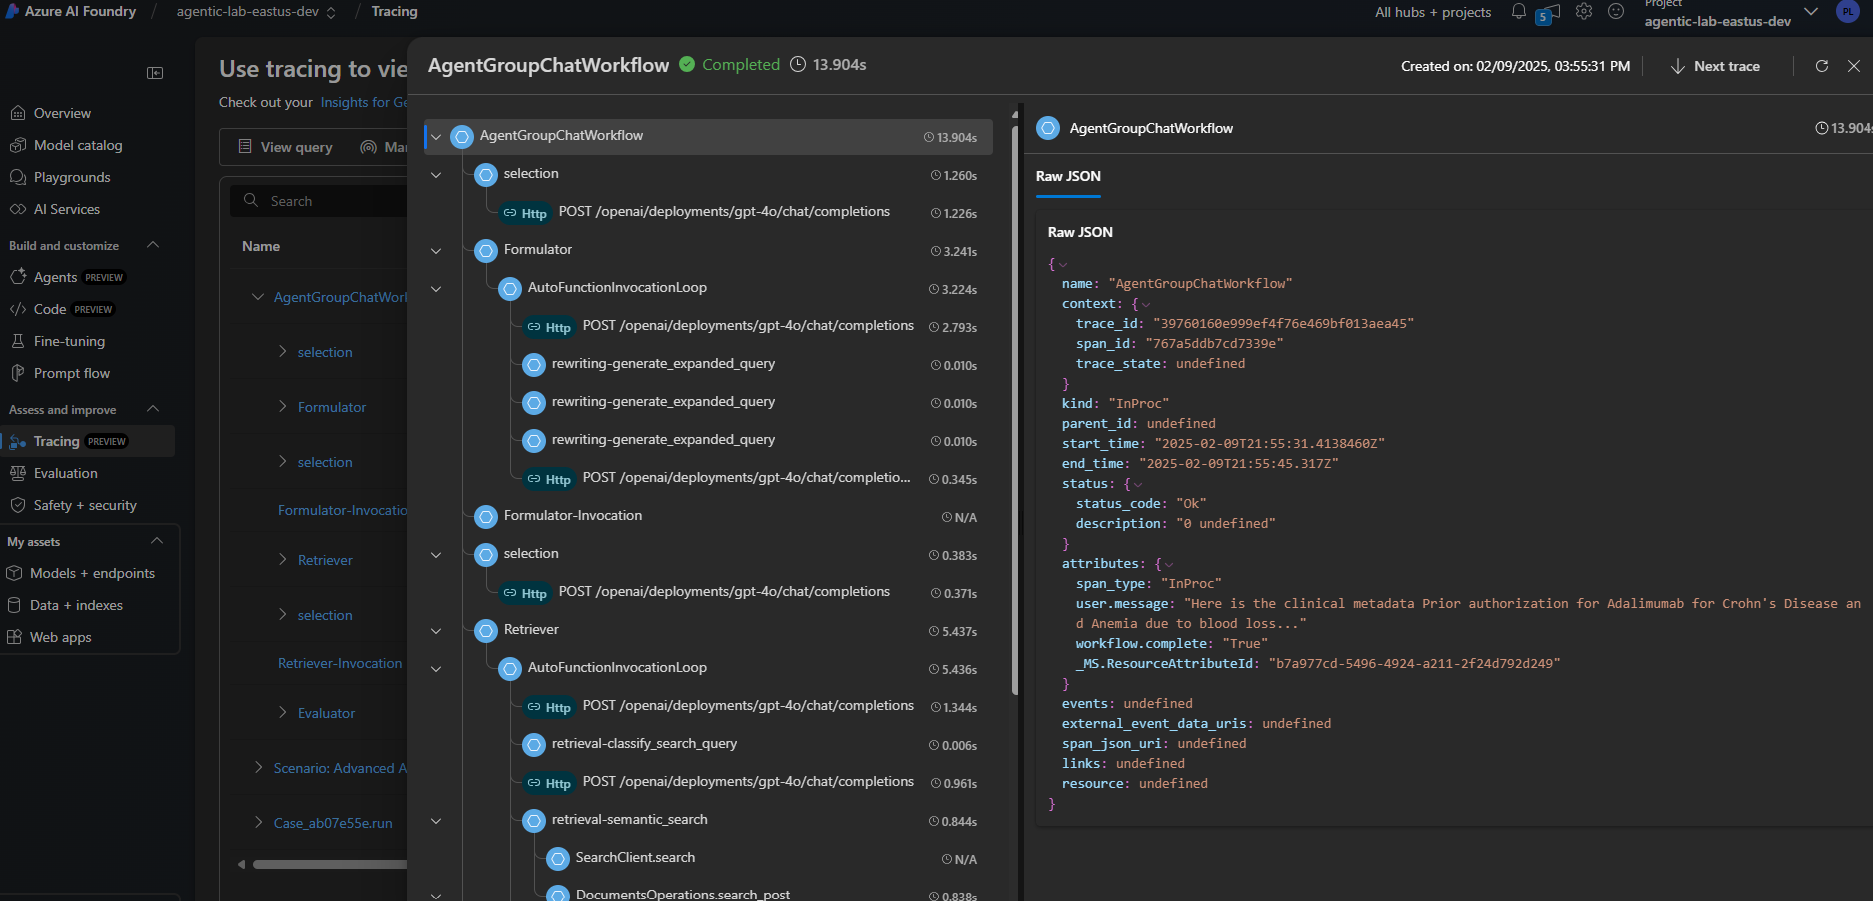

In [25]:
chat.history
from src.agenticai.utils import get_policies_from_chat

policies = get_policies_from_chat(chat)
print("Extracted Policies:", policies)

Extracted Policies: ['https://storageaeastusfactory.blob.core.windows.net/pre-auth-policies/policies_ocr/001.pdf']


Awesome! We were able to find the right policy based on the search query `Find me the policy for Adalimumab for Crohn's Disease and Anemia due to blood loss` passed!